**Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic**

## **Import Lib**

In [1]:
import numpy as np #numerical computation 
import pandas as pd #data wrangling 
import matplotlib.pyplot as plt #plotting package 
#Next line helps with rendering plots 
%matplotlib inline 
import matplotlib as mpl #add'l plotting functionality 
mpl.rcParams['figure.dpi'] = 400 #high res figures 
import graphviz #to visualize decision trees 
import re
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV 

## **Import dataset**

In [2]:
train = pd.read_csv('../dataset/train.csv') 
test = pd.read_csv('../dataset/test.csv') 

In [3]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

<>:39: SyntaxWarning: invalid escape sequence '\.'
<>:39: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Pht Technology\AppData\Local\Temp\ipykernel_18812\933489935.py:39: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)


In [4]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [6]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin', 
            'FamilySize', 'IsAlone', 'Title']

X_train, X_test, y_train, y_test = \
    train_test_split(train[features].values,
    train['Survived'].values,
    test_size=0.2, random_state=24)

## **Mô hình Decision Tree Classifier**

### Xây dựng mô hình

In [7]:
# the tree will grow to a depth of at most 2 
dt = tree.DecisionTreeClassifier(max_depth=2) 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


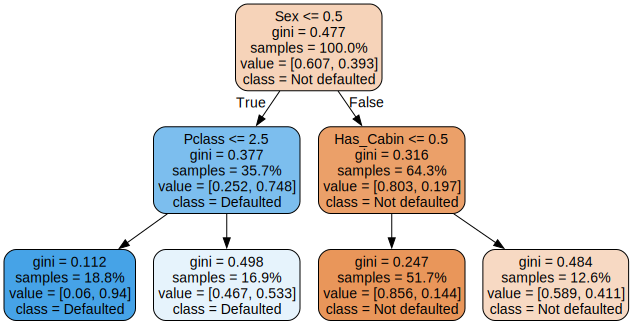

In [8]:
dot_data = tree.export_graphviz(dt, 
                out_file=None, 
                filled=True, 
                rounded=True, 
                feature_names=features,
                proportion=True, 
                class_names=['Not defaulted', 'Defaulted']) 
graph = graphviz.Source(dot_data) 
graph

### Tìm tham số tối ưu

In [9]:
params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]} #parameters 
dt = tree.DecisionTreeClassifier() #tree modal 
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc', 
               n_jobs=None, refit=True, cv=4, verbose=1, 
               error_score=np.nan, 
               return_train_score=True) # cv is the best model. 
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


### Vẽ biểu đồ đánh giá mô hình

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Pht Technology\AppData\Local\Temp\ipykernel_18812\758487805.py:8: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE training scores')
C:\Users\Pht Technology\AppData\Local\Temp\ipykernel_18812\758487805.py:12: SyntaxWarning: invalid escape sequence '\p'
  label='Mean $\pm$ 1 SE testing scores')


Text(0, 0.5, 'ROC AUC')

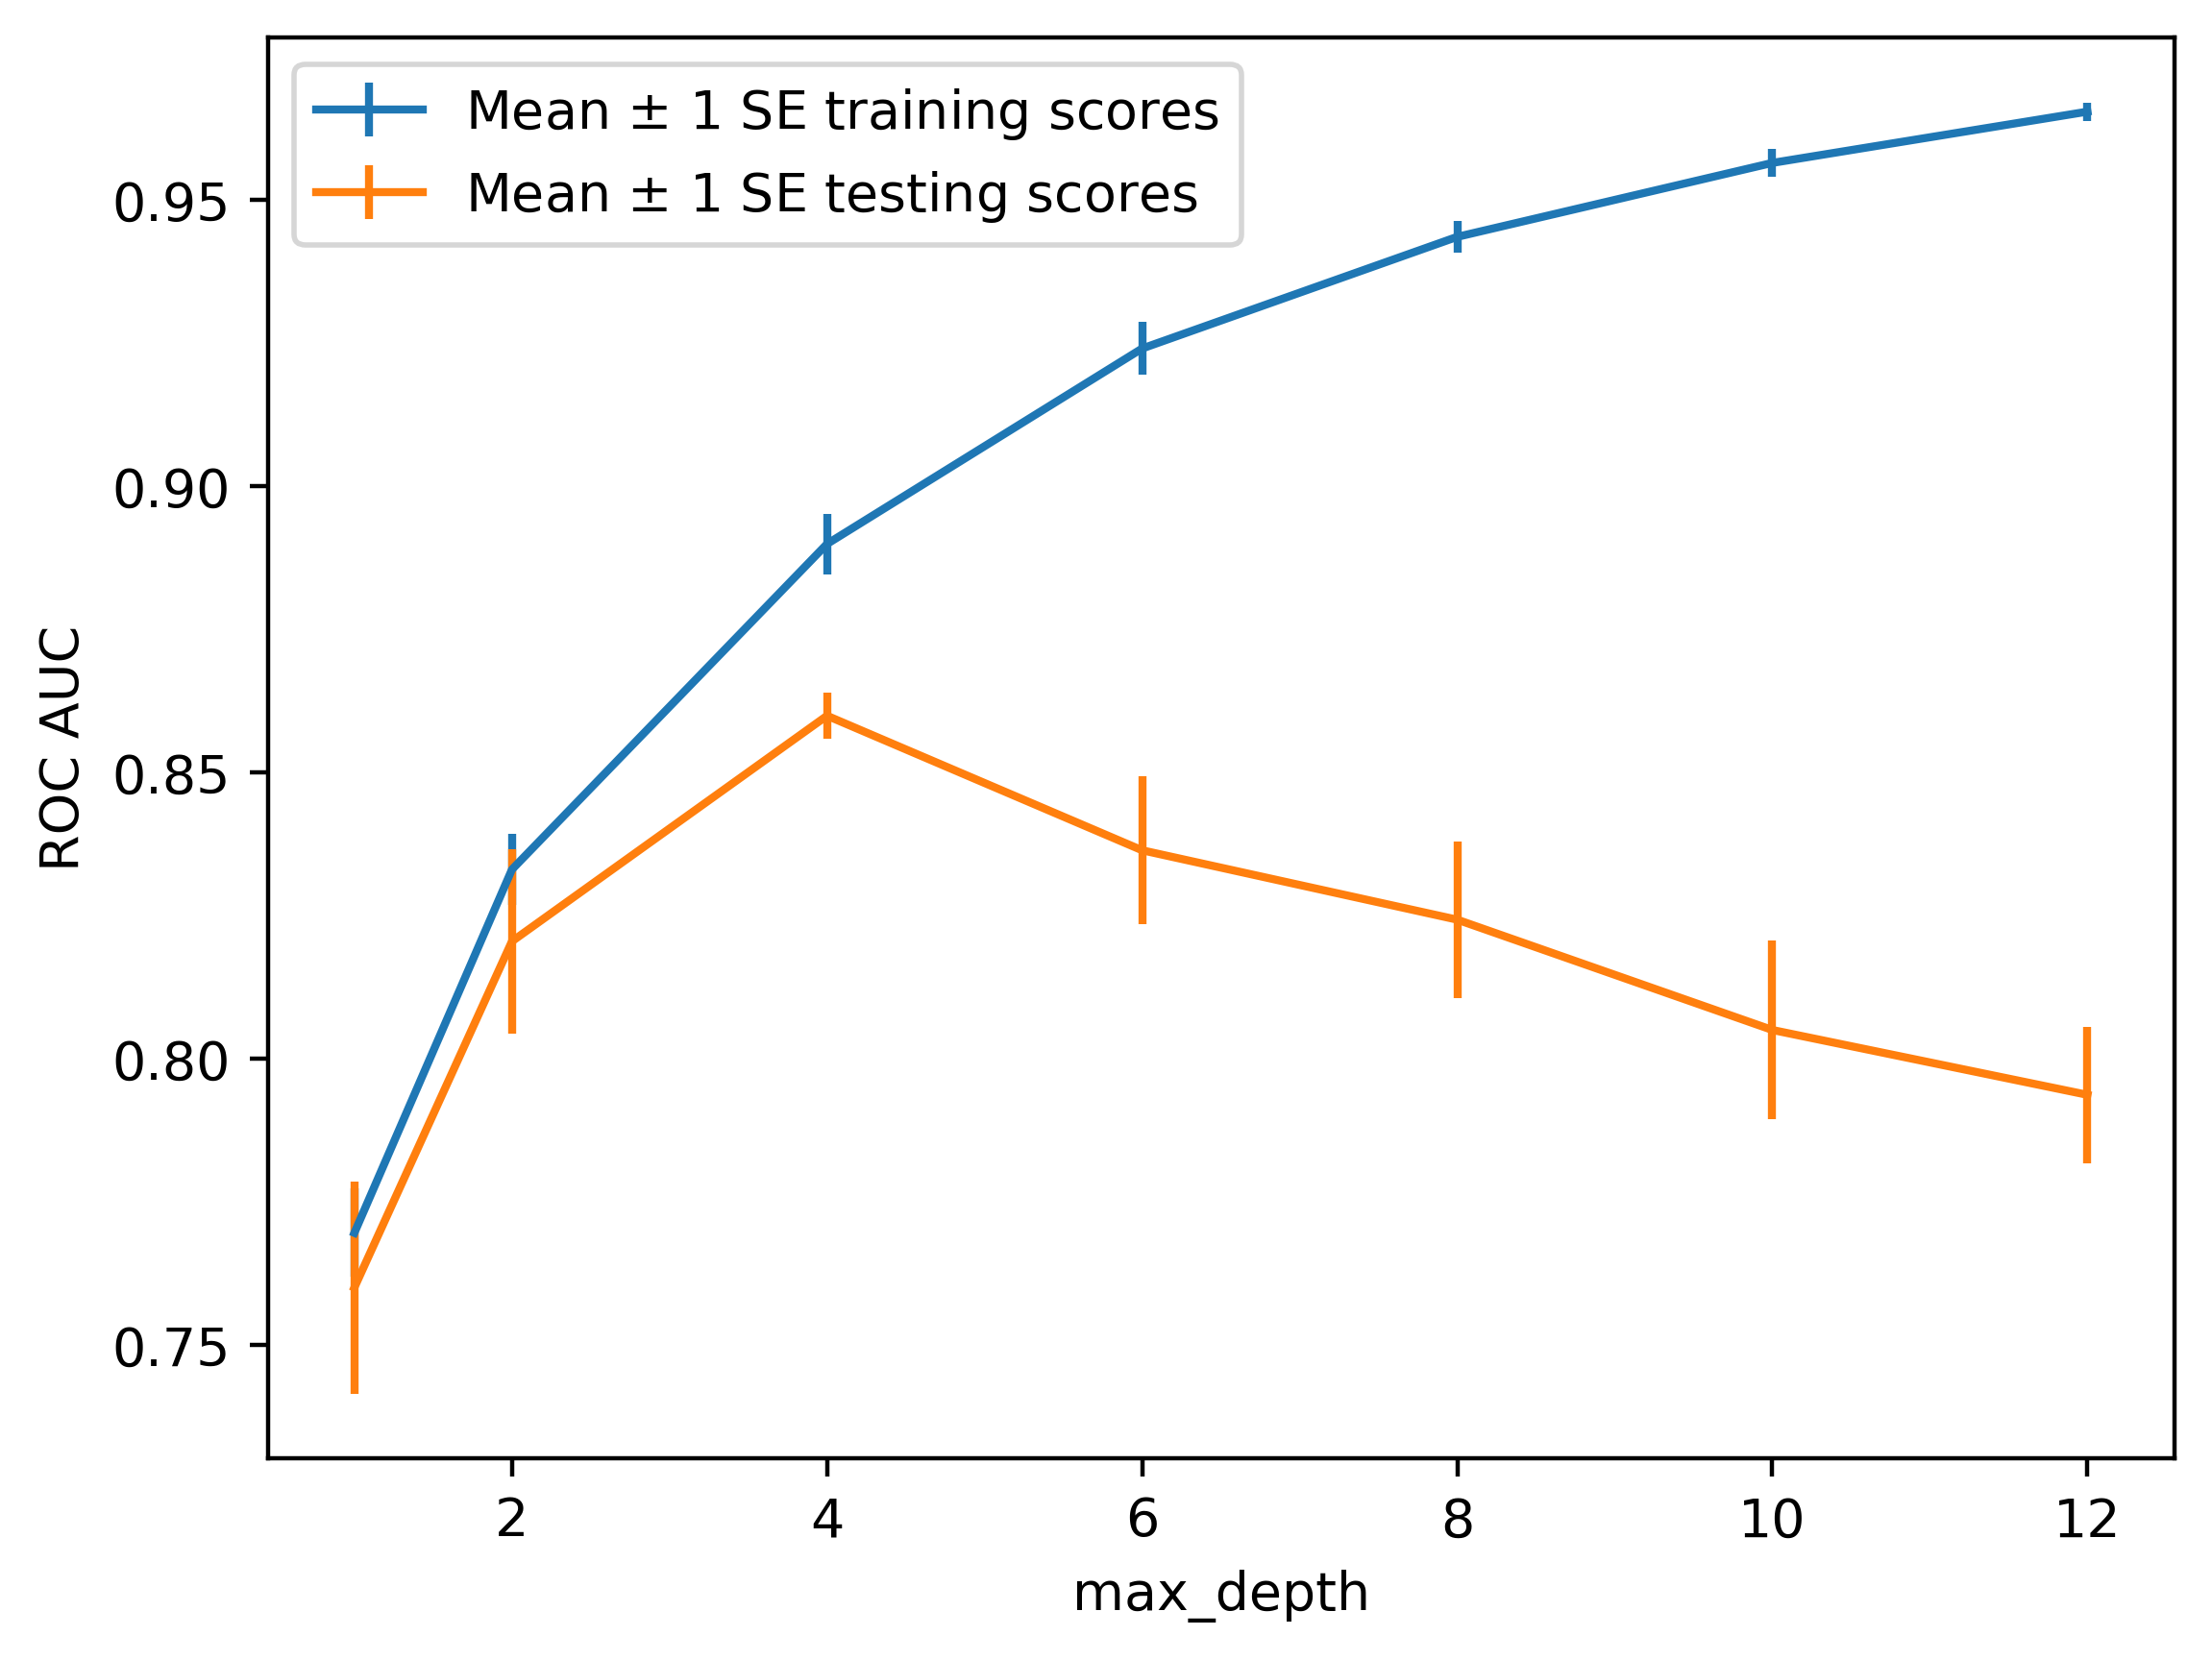

In [10]:
cv_results_df = pd.DataFrame(cv.cv_results_) 
#View the names of the remaining columns in the results DataFrame 
cv_results_df.columns 
ax = plt.axes() 
ax.errorbar(cv_results_df['param_max_depth'], 
            cv_results_df['mean_train_score'], 
            yerr=cv_results_df['std_train_score']/np.sqrt(4), 
            label='Mean $\pm$ 1 SE training scores') 
ax.errorbar(cv_results_df['param_max_depth'], 
            cv_results_df['mean_test_score'], 
            yerr=cv_results_df['std_test_score']/np.sqrt(4), 
            label='Mean $\pm$ 1 SE testing scores') 
ax.legend() 
plt.xlabel('max_depth') 
plt.ylabel('ROC AUC') 

## **RandomForestClassifier**

### Xây dựng mô hình

In [11]:
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier\
  (n_estimators=10, criterion='gini', max_depth=3, 
   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
   max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
   bootstrap=True, oob_score=False, n_jobs=None, 
   random_state=4, verbose=0, warm_start=False, class_weight=None) 

### **Tìm tham số tối ưu**

In [12]:
#a parameter  grid for  this  exercise in order  to search  the numbers  of trees, ranging from 10 to 100 by 10s 
rf_params_ex = {'n_estimators':list(range(10,110,10))} 
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex, 
                        scoring='roc_auc', n_jobs=None, 
                        refit=True, cv=4, verbose=1, 
                        error_score=np.nan, 
                        return_train_score=True) 
cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


,estimator,RandomForestC...andom_state=4)
,param_grid,"{'n_estimators': [10, 20, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,40


### Vẽ biểu đồ đánh giá mô hình

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Pht Technology\AppData\Local\Temp\ipykernel_18812\1761324305.py:12: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')


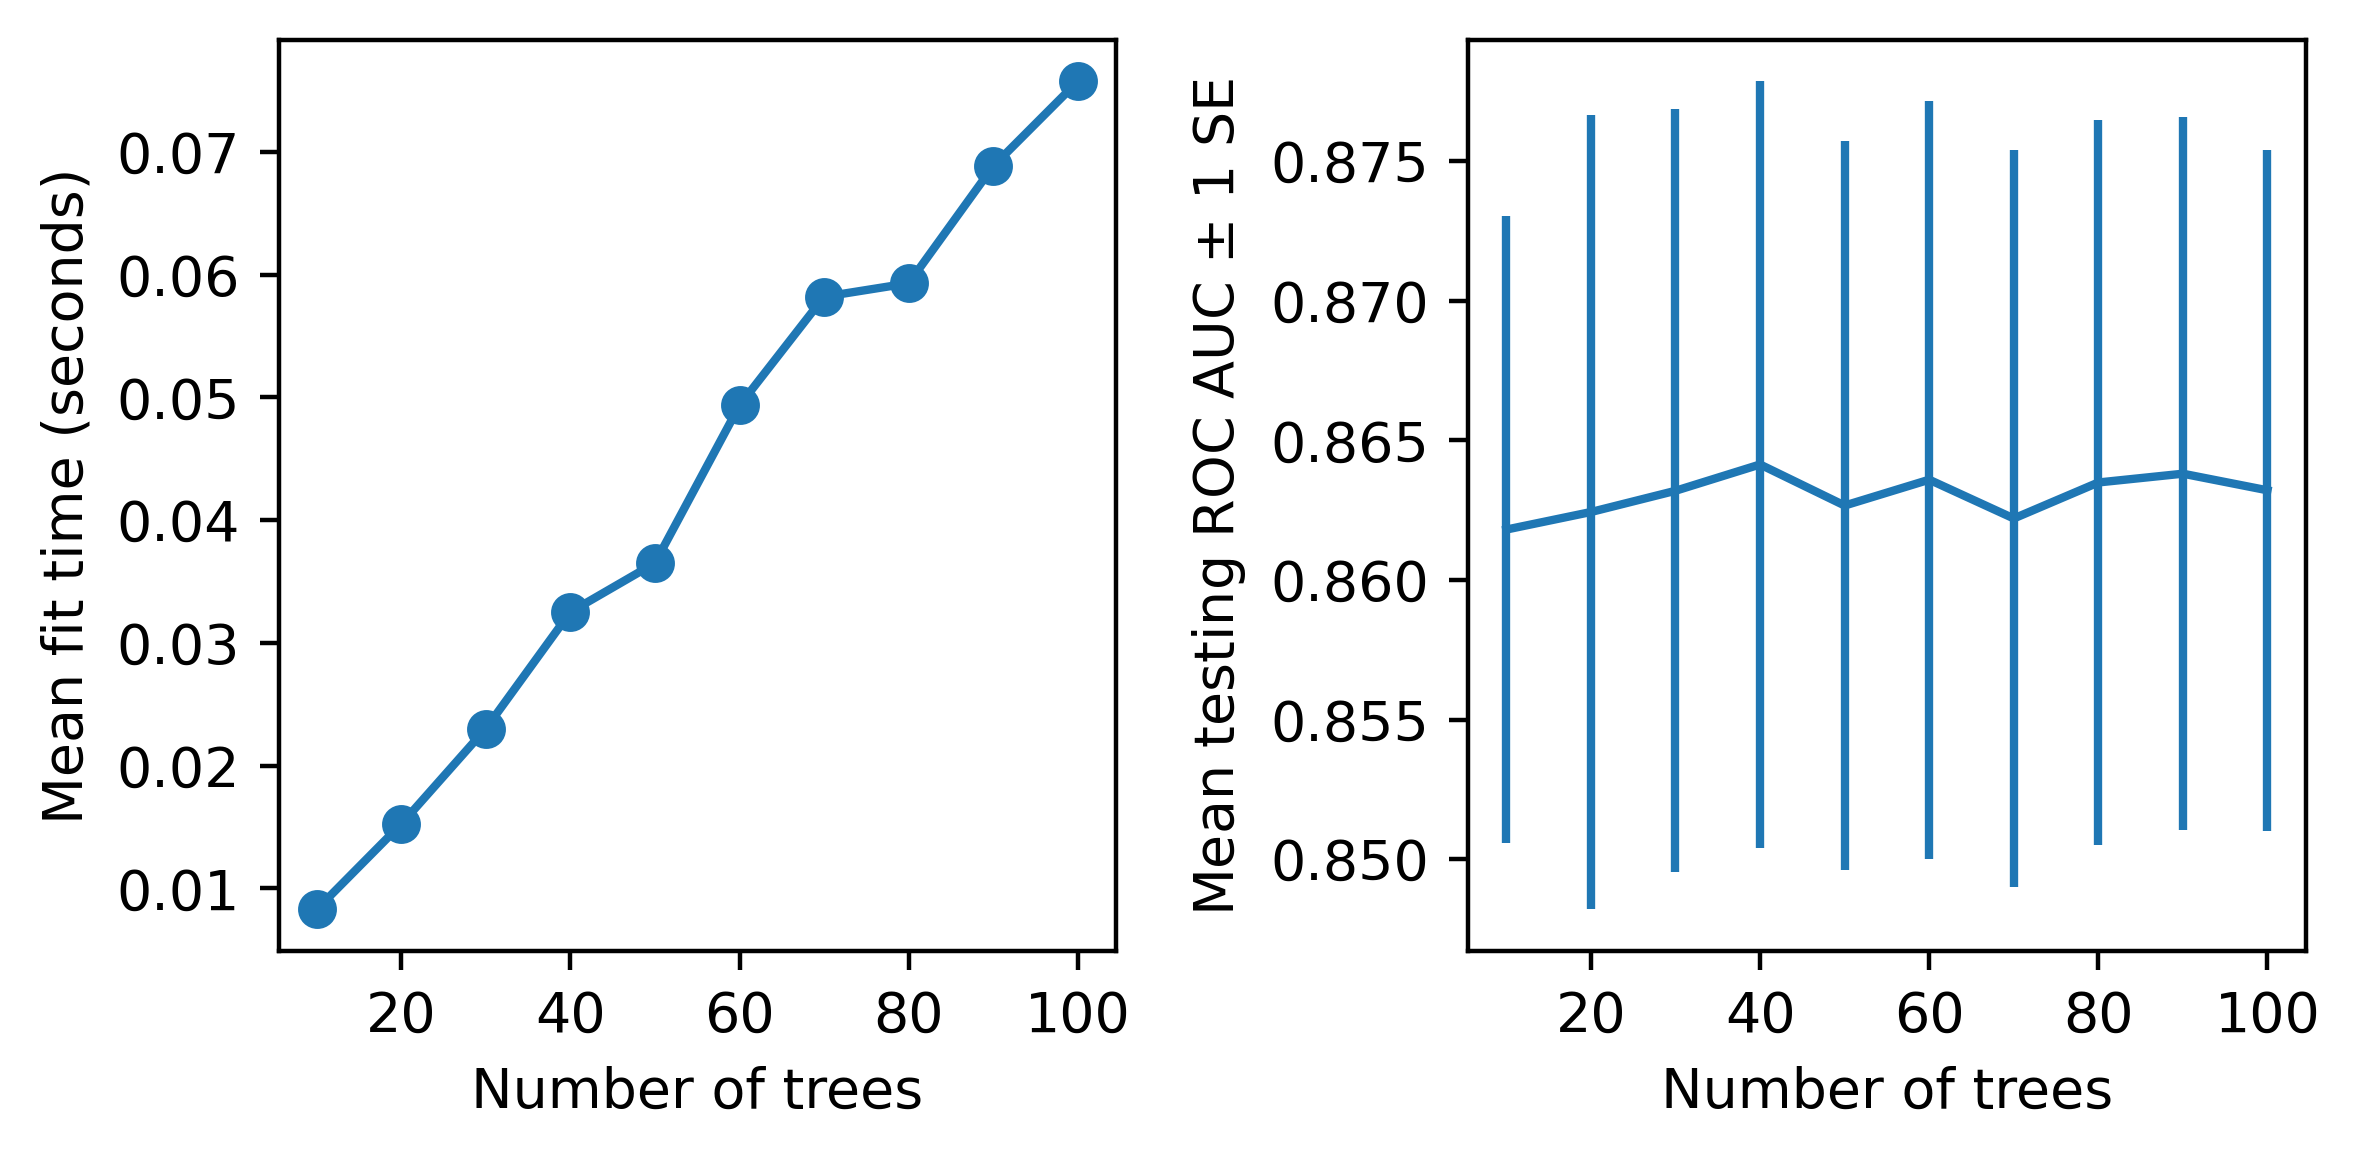

In [13]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_) 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3)) 
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'], 
            cv_rf_ex_results_df['mean_fit_time'], 
            '-o') 
axs[0].set_xlabel('Number of trees') 
axs[0].set_ylabel('Mean fit time (seconds)') 
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'], 
                cv_rf_ex_results_df['mean_test_score'], 
                yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4)) 
axs[1].set_xlabel('Number of trees') 
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ') 
plt.tight_layout()

### **Xem tham số tốt nhất của rừng cây**

<Axes: >

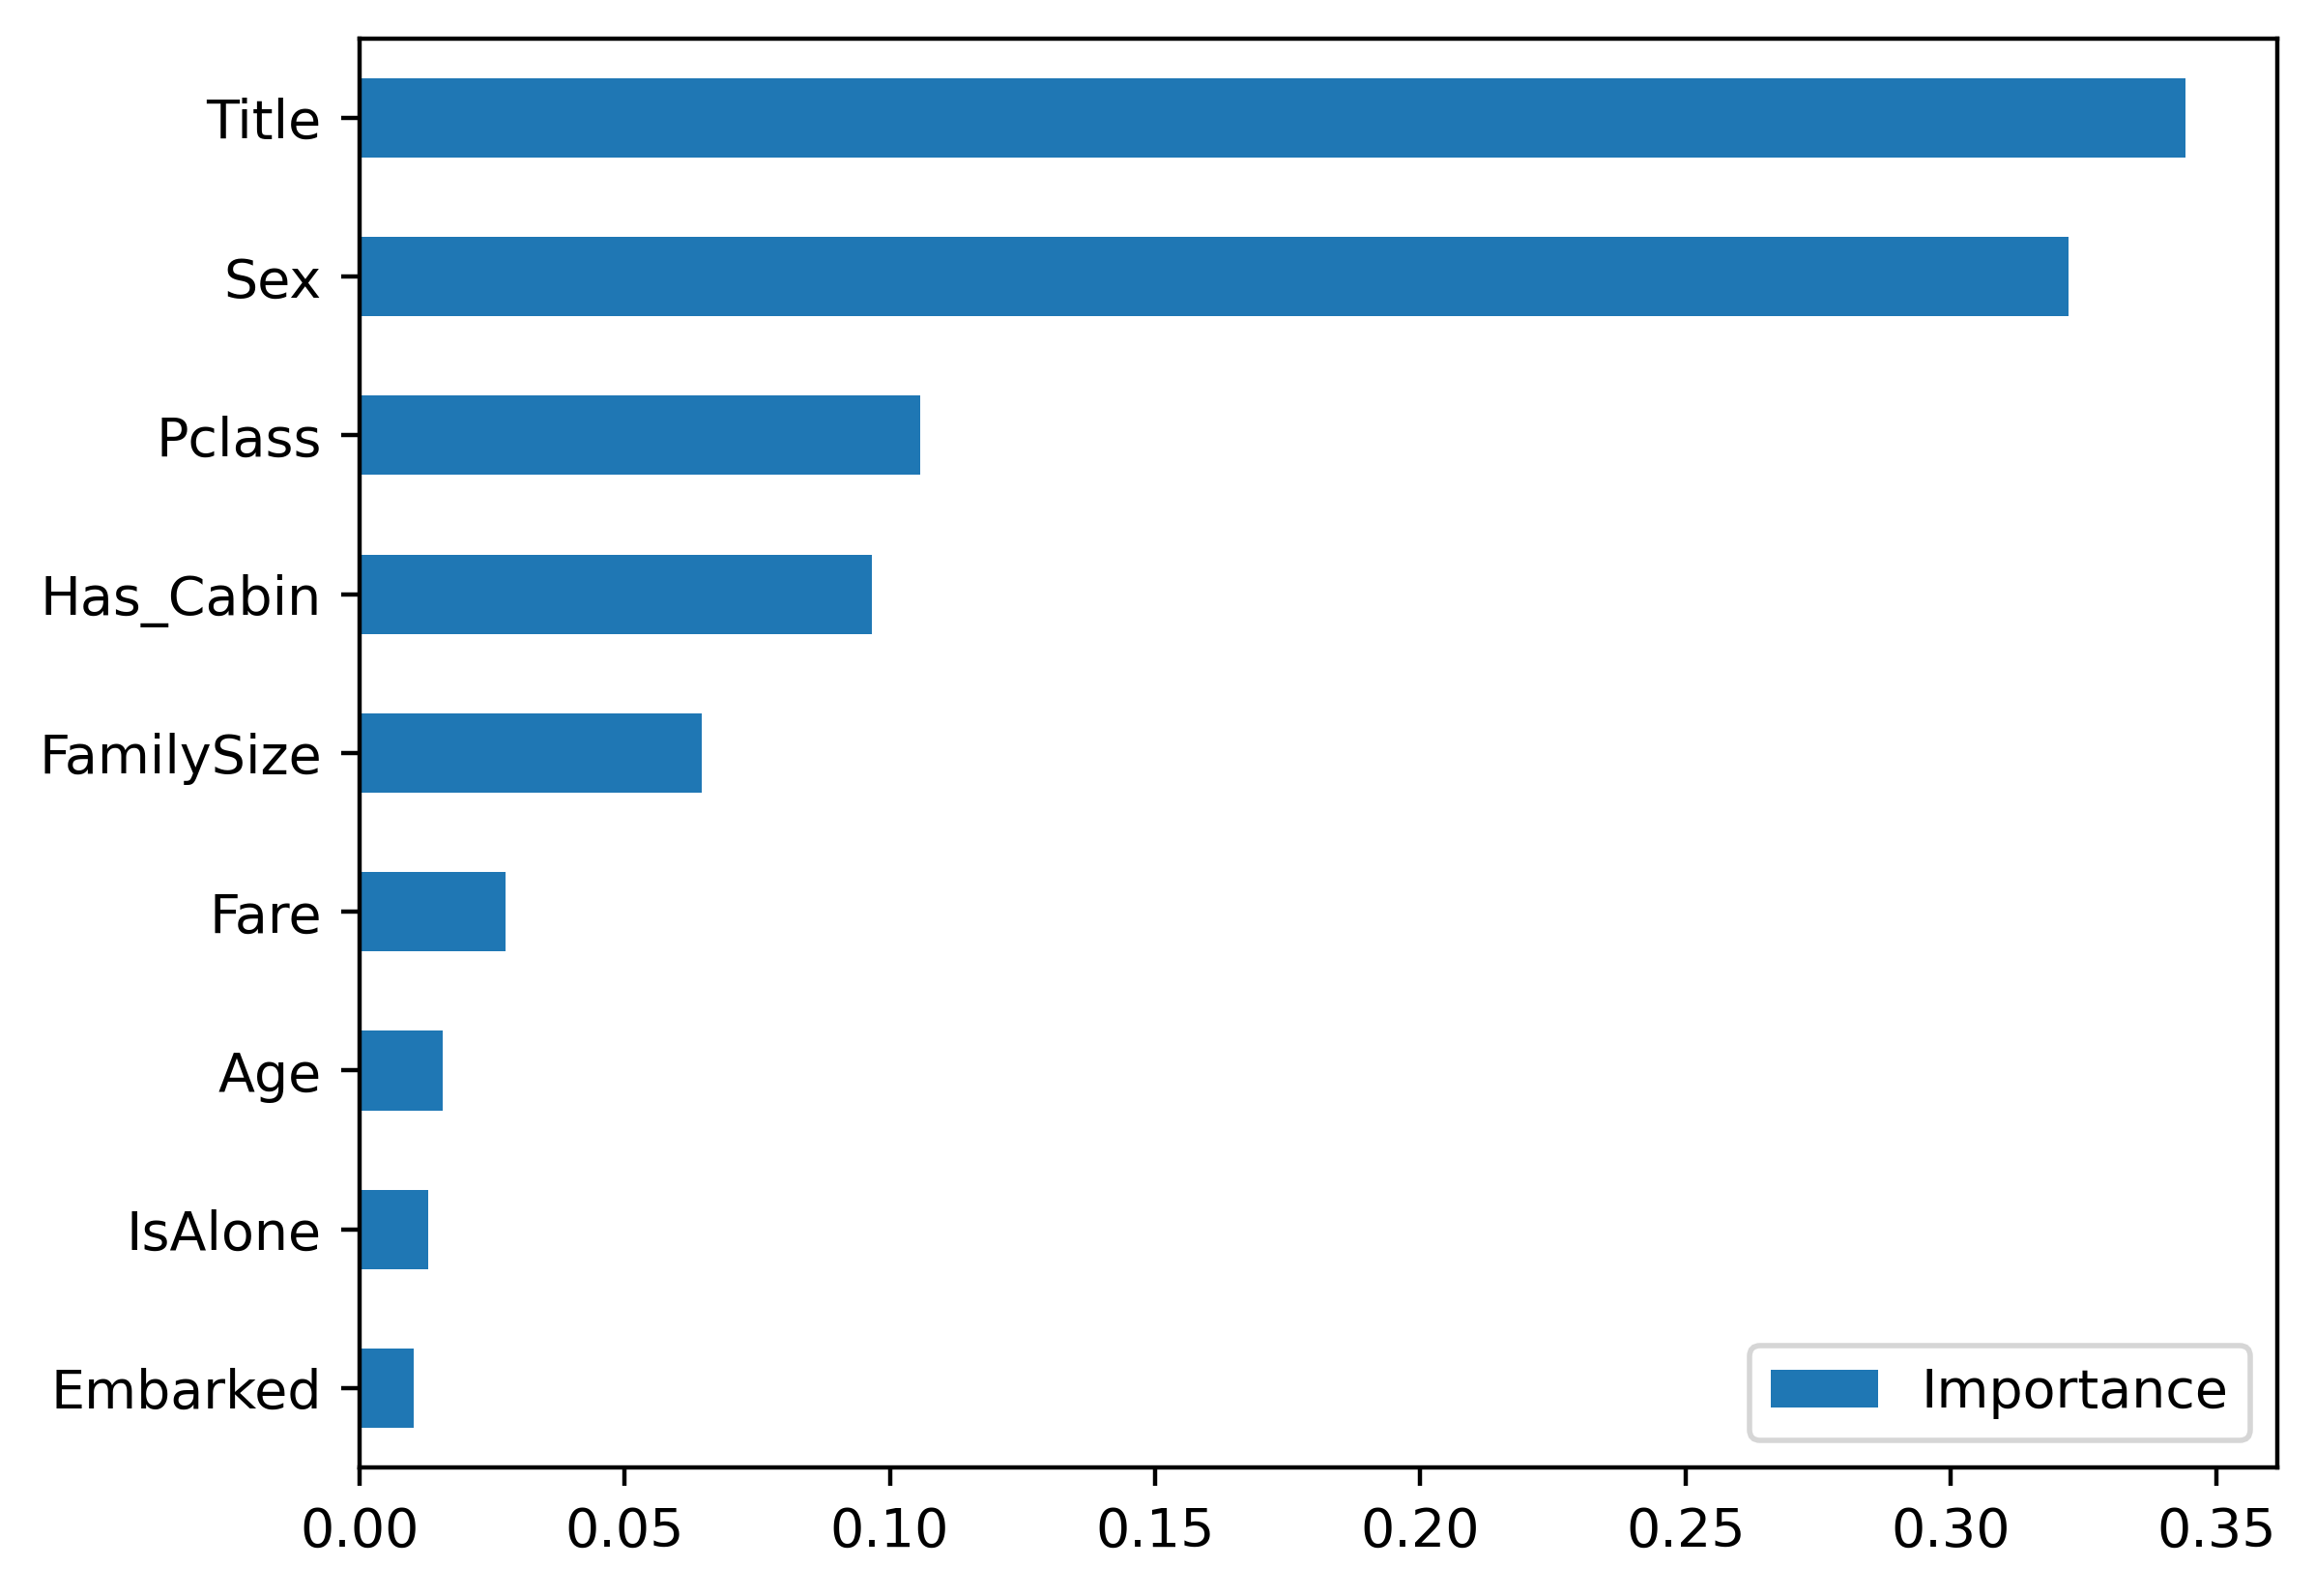

In [14]:
# {'n_estimators': 50} 
cv_rf_ex.best_params_ 
# the feature names and importances 
feat_imp_df = pd.DataFrame({ 
    'Importance':cv_rf_ex.best_estimator_.feature_importances_}, 
    index=features) 
feat_imp_df.sort_values('Importance', ascending=True).plot.barh()